In [ ]:
pip install transformers

In [ ]:
pip install scikit-learn

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 782/782 [08:46<00:00,  1.49 batches/s]


Average training loss for epoch 1: 0.3349


Calculating Test Loss - Epoch 1: 100%|██████████| 782/782 [02:55<00:00,  4.44 batches/s]


Average test loss for epoch 1: 0.2696


Epoch 2: 100%|██████████| 782/782 [08:55<00:00,  1.46 batches/s]


Average training loss for epoch 2: 0.2056


Calculating Test Loss - Epoch 2: 100%|██████████| 782/782 [02:57<00:00,  4.42 batches/s]


Average test loss for epoch 2: 0.3315


Epoch 3: 100%|██████████| 782/782 [08:55<00:00,  1.46 batches/s]


Average training loss for epoch 3: 0.1179


Calculating Test Loss - Epoch 3: 100%|██████████| 782/782 [02:56<00:00,  4.43 batches/s]


Average test loss for epoch 3: 0.4012


Epoch 4: 100%|██████████| 782/782 [08:55<00:00,  1.46 batches/s]


Average training loss for epoch 4: 0.0656


Calculating Test Loss - Epoch 4: 100%|██████████| 782/782 [02:56<00:00,  4.43 batches/s]


Average test loss for epoch 4: 0.5088


Epoch 5: 100%|██████████| 782/782 [08:55<00:00,  1.46 batches/s]


Average training loss for epoch 5: 0.0361


Calculating Test Loss - Epoch 5: 100%|██████████| 782/782 [02:56<00:00,  4.42 batches/s]


Average test loss for epoch 5: 0.5634


Epoch 6: 100%|██████████| 782/782 [08:54<00:00,  1.46 batches/s]


Average training loss for epoch 6: 0.0228


Calculating Test Loss - Epoch 6: 100%|██████████| 782/782 [02:56<00:00,  4.44 batches/s]


Average test loss for epoch 6: 0.6552


Epoch 7: 100%|██████████| 782/782 [08:55<00:00,  1.46 batches/s]


Average training loss for epoch 7: 0.0134


Calculating Test Loss - Epoch 7: 100%|██████████| 782/782 [02:56<00:00,  4.42 batches/s]


Average test loss for epoch 7: 0.7086


Epoch 8: 100%|██████████| 782/782 [08:56<00:00,  1.46 batches/s]


Average training loss for epoch 8: 0.0088


Calculating Test Loss - Epoch 8: 100%|██████████| 782/782 [02:56<00:00,  4.44 batches/s]


Average test loss for epoch 8: 0.7245


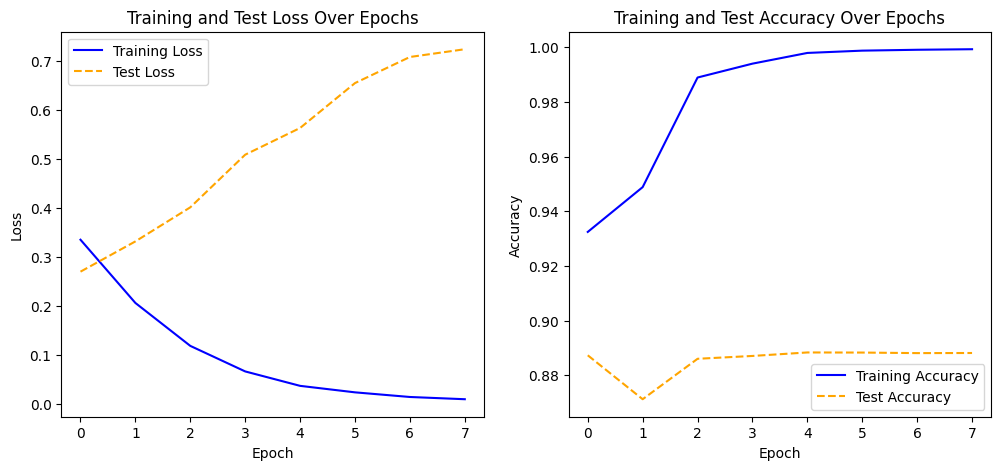

<Figure size 800x800 with 0 Axes>

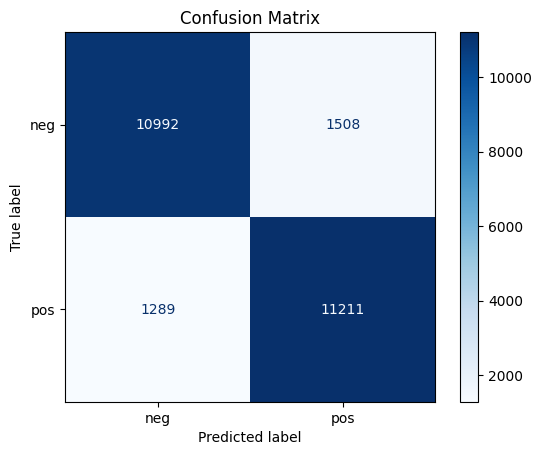

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load IMDB dataset
imdb_train_df = pd.read_csv('train.csv')  
imdb_test_df = pd.read_csv('test.csv')    

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Mapping for sentiment labels
sentiment_label_mapping = {'neg': 0, 'pos': 1}

# Encode the text data
def encode_text(texts, sentiments, max_length=128):
    input_ids = []
    attention_masks = []
    labels = []

    for text, sentiment in zip(texts, sentiments):
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
            return_attention_mask=True
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
        labels.append(sentiment_label_mapping[sentiment])

    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0), torch.tensor(labels)

# encode the training and testing data
imdb_train_inputs, imdb_train_masks, imdb_train_labels = encode_text(imdb_train_df['text'].values, imdb_train_df['sentiment'].values)
imdb_test_inputs, imdb_test_masks, imdb_test_labels = encode_text(imdb_test_df['text'].values, imdb_test_df['sentiment'].values)

# creating batch file
batch_size = 32
imdb_train_data = TensorDataset(imdb_train_inputs, imdb_train_masks, imdb_train_labels)
imdb_train_sampler = RandomSampler(imdb_train_data)
imdb_train_dataloader = DataLoader(imdb_train_data, sampler=imdb_train_sampler, batch_size=batch_size)
imdb_test_data = TensorDataset(imdb_test_inputs, imdb_test_masks, imdb_test_labels)
imdb_test_sampler = SequentialSampler(imdb_test_data)
imdb_test_dataloader = DataLoader(imdb_test_data, sampler=imdb_test_sampler, batch_size=batch_size)

# model initialization
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(sentiment_label_mapping))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 8  # Set to 8 epochs
total_steps = len(imdb_train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Lists to store training accuracy and test accuracy for each epoch
imdb_train_accuracies = []
imdb_test_accuracies = []

# Lists to store training loss and test loss for each epoch
imdb_train_losses = []
imdb_test_losses = []

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(imdb_train_dataloader, desc=f'Epoch {epoch + 1}', unit=' batches'):
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch

        model.zero_grad()

        outputs = model(
            input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(imdb_train_dataloader)
    imdb_train_losses.append(avg_train_loss)  # Store the training loss for visualization
    print(f'Average training loss for epoch {epoch + 1}: {avg_train_loss:.4f}')

    # Calculate training accuracy after each epoch
    model.eval()
    imdb_train_preds = []
    imdb_train_true = []

    for batch in tqdm(imdb_train_dataloader, desc=f'Evaluating (Train) - Epoch {epoch + 1}', unit=' batches'):
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)

        logits = outputs.logits
        preds = np.argmax(logits.to('cpu').numpy(), axis=1)
        imdb_train_preds.extend(preds)
        imdb_train_true.extend(labels.to('cpu').numpy())

    train_accuracy = accuracy_score(imdb_train_true, imdb_train_preds)
    imdb_train_accuracies.append(train_accuracy)

    # Calculate test accuracy after each epoch
    model.eval()
    imdb_test_preds = []
    imdb_test_true = []

    for batch in tqdm(imdb_test_dataloader, desc=f'Evaluating (Test) - Epoch {epoch + 1}', unit=' batches'):
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)

        logits = outputs.logits
        preds = np.argmax(logits.to('cpu').numpy(), axis=1)
        imdb_test_preds.extend(preds)
        imdb_test_true.extend(labels.to('cpu').numpy())

    test_accuracy = accuracy_score(imdb_test_true, imdb_test_preds)
    imdb_test_accuracies.append(test_accuracy)

    # Store test loss
    model.eval()
    total_test_loss = 0

    for batch in tqdm(imdb_test_dataloader, desc=f'Calculating Test Loss - Epoch {epoch + 1}', unit=' batches'):
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch

        with torch.no_grad():
            outputs = model(
                input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

        loss = outputs.loss
        total_test_loss += loss.item()

    avg_test_loss = total_test_loss / len(imdb_test_dataloader)
    imdb_test_losses.append(avg_test_loss)  # Store the test loss for visualization
    print(f'Average test loss for epoch {epoch + 1}: {avg_test_loss:.4f}')

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(imdb_train_losses, label='Training Loss', color='blue')
plt.plot(imdb_test_losses, label='Test Loss', color='orange', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(imdb_train_accuracies, label='Training Accuracy', color='blue')
plt.plot(imdb_test_accuracies, label='Test Accuracy', color='orange', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Over Epochs')
plt.legend()
plt.show()

# Confusion matrix
conf_matrix = confusion_matrix(imdb_test_true, imdb_test_preds)
class_names = list(sentiment_label_mapping.keys())

plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
new_accuracy = accuracy_score(imdb_test_true, imdb_test_preds)
print(f'Accuracy on the new test set: {new_accuracy:.4f}')

Accuracy on the new test set: 0.8881


In [ ]:
# Your own text for testing
your_text = "This movie is amazing!"

# Encode the text using the tokenizer
encoded_text = tokenizer.encode_plus(
    your_text,
    add_special_tokens=True,
    max_length=128,
    padding='max_length',
    truncation=True,
    return_tensors='pt',
    return_attention_mask=True
)

# Extract input_ids and attention_mask
input_ids = encoded_text['input_ids']
attention_mask = encoded_text['attention_mask']

# Move tensors to the appropriate device
input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)

# Make a forward pass to get the model's prediction
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)

logits = outputs.logits
prediction = torch.argmax(logits, dim=1).item()

# Map the prediction back to the original label
predicted_label = [key for key, value in sentiment_label_mapping.items() if value == prediction][0]

print(f"Your text: {your_text}")
print(f"Predicted sentiment: {predicted_label}")


Your text: This movie is amazing!
Predicted sentiment: pos


In [ ]:
# Your own text for testing
your_text = "Eh, they're feeling kinda meh"

# Encode the text using the tokenizer
encoded_text = tokenizer.encode_plus(
    your_text,
    add_special_tokens=True,
    max_length=128,
    padding='max_length',
    truncation=True,
    return_tensors='pt',
    return_attention_mask=True
)

# Extract input_ids and attention_mask
input_ids = encoded_text['input_ids']
attention_mask = encoded_text['attention_mask']

# Move tensors to the appropriate device
input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)

# Make a forward pass to get the model's prediction
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)

logits = outputs.logits
prediction = torch.argmax(logits, dim=1).item()

# Map the prediction back to the original label
predicted_label = [key for key, value in sentiment_label_mapping.items() if value == prediction][0]

print(f"Your text: {your_text}")
print(f"Predicted sentiment: {predicted_label}")


Your text: Eh, they're feeling kinda meh
Predicted sentiment: neg


In [ ]:
# Your own text for testing
your_text = "Ranbir Kapoor's 'Animal' Roars into Cinematic Brilliance "

# Encode the text using the tokenizer
encoded_text = tokenizer.encode_plus(
    your_text,
    add_special_tokens=True,
    max_length=128,
    padding='max_length',
    truncation=True,
    return_tensors='pt',
    return_attention_mask=True
)

# Extract input_ids and attention_mask
input_ids = encoded_text['input_ids']
attention_mask = encoded_text['attention_mask']

# Move tensors to the appropriate device
input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)

# Make a forward pass to get the model's prediction
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)

logits = outputs.logits
prediction = torch.argmax(logits, dim=1).item()

# Map the prediction back to the original label
predicted_label = [key for key, value in sentiment_label_mapping.items() if value == prediction][0]

print(f"Your text: {your_text}")
print(f"Predicted sentiment: {predicted_label}")


Your text: Ranbir Kapoor's 'Animal' Roars into Cinematic Brilliance 
Predicted sentiment: pos


In [ ]:
# Your own text for testing
your_text = "The Flash (2023)” bursts onto the screen with electrifying speed, delivering a superhero spectacle that lives up to its much-anticipated DC Universe status. The film offers an exhilarating experience that combines jaw-dropping action, mind-bending time travel, and unexpected twists, all of which had me on the edge of my seat."

# Encode the text using the tokenizer
encoded_text = tokenizer.encode_plus(
    your_text,
    add_special_tokens=True,
    max_length=128,
    padding='max_length',
    truncation=True,
    return_tensors='pt',
    return_attention_mask=True
)

# Extract input_ids and attention_mask
input_ids = encoded_text['input_ids']
attention_mask = encoded_text['attention_mask']

# Move tensors to the appropriate device
input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)

# Make a forward pass to get the model's prediction
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)

logits = outputs.logits
prediction = torch.argmax(logits, dim=1).item()

# Map the prediction back to the original label
predicted_label = [key for key, value in sentiment_label_mapping.items() if value == prediction][0]

print(f"Your text: {your_text}")
print(f"Predicted sentiment: {predicted_label}")


Your text: The Flash (2023)” bursts onto the screen with electrifying speed, delivering a superhero spectacle that lives up to its much-anticipated DC Universe status. The film offers an exhilarating experience that combines jaw-dropping action, mind-bending time travel, and unexpected twists, all of which had me on the edge of my seat.
Predicted sentiment: pos


In [ ]:
# Your own text for testing
your_text = " Animal proves to be a colossal disappointment that leaves audiences questioning the sanity of its creators lots of critics are giving paid five star or four star reviews do not believe them this movie is nothing but a sob begging for the attention from his billionaire father such plot is stretched for almost four hours got no idea which person wrote such a story and ranbir agreed to do such a film when his career is already sinking Director Sandeep Vanga known for his previous work in Kabir Singh fails to replicate his earlier success instead delivering a convoluted storyline that lacks direction and purpose Vanga has a thing with misogyny and films objectifying women in kabir singh shahid is slapping kiara and in animal ranbir is glorifying infidellity by claiming its right in the name of his father what could go more pathetic than this "

# Encode the text using the tokenizer
encoded_text = tokenizer.encode_plus(
    your_text,
    add_special_tokens=True,
    max_length=128,
    padding='max_length',
    truncation=True,
    return_tensors='pt',
    return_attention_mask=True
)

# Extract input_ids and attention_mask
input_ids = encoded_text['input_ids']
attention_mask = encoded_text['attention_mask']

# Move tensors to the appropriate device
input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)

# Make a forward pass to get the model's prediction
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)

logits = outputs.logits
prediction = torch.argmax(logits, dim=1).item()

# Map the prediction back to the original label
predicted_label = [key for key, value in sentiment_label_mapping.items() if value == prediction][0]

print(f"Your text: {your_text}")
print(f"Predicted sentiment: {predicted_label}")


Your text:  Animal proves to be a colossal disappointment that leaves audiences questioning the sanity of its creators lots of critics are giving paid five star or four star reviews do not believe them this movie is nothing but a sob begging for the attention from his billionaire father such plot is stretched for almost four hours got no idea which person wrote such a story and ranbir agreed to do such a film when his career is already sinking Director Sandeep Vanga known for his previous work in Kabir Singh fails to replicate his earlier success instead delivering a convoluted storyline that lacks direction and purpose Vanga has a thing with misogyny and films objectifying women in kabir singh shahid is slapping kiara and in animal ranbir is glorifying infidellity by claiming its right in the name of his father what could go more pathetic than this 
Predicted sentiment: neg
